<a href="https://colab.research.google.com/github/Jdean4747/Data5600HW/blob/main/KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [61]:
df = pd.read_csv("/content/bikeshare.csv")

In [62]:
df.head()

,season,yr,mnth,hr,holiday,weekday,notbizday,weathersit,temp,hum,windspeed,dteday,cnt
0,1,0,1,0,0,6,1,1,-1.334609,0.947345,-1.553844,2011-01-01,16
1,1,0,1,1,0,6,1,1,-1.438475,0.895513,-1.553844,2011-01-01,40
2,1,0,1,2,0,6,1,1,-1.438475,0.895513,-1.553844,2011-01-01,32
3,1,0,1,3,0,6,1,1,-1.334609,0.636351,-1.553844,2011-01-01,13
4,1,0,1,4,0,6,1,1,-1.334609,0.636351,-1.553844,2011-01-01,1


In [63]:
df = df.drop(columns=["dteday"])
df = df.drop(columns=["holiday"])
df = df.drop(columns=["weekday"])
df = df.drop(columns=["notbizday"])
x = df.drop(columns=["cnt"])
y = df["cnt"]

In [64]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [65]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(x_train, y_train)

KNeighborsRegressor()

In [66]:
y_hat = knn.predict(x_test)
df_pred = pd.DataFrame({"Actual": y_test, "Predicted": y_hat})

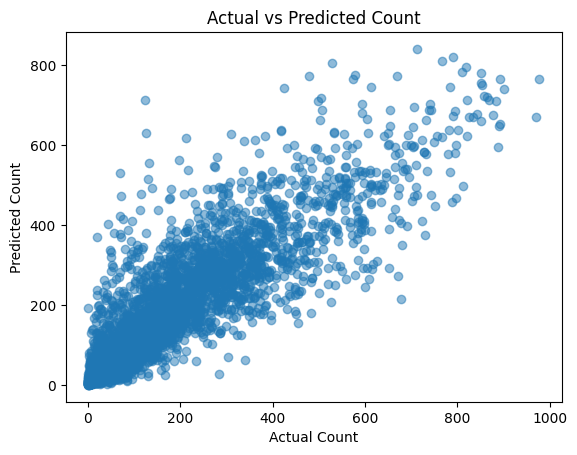

In [67]:
plt.scatter(y_test, y_hat, alpha=0.5)
plt.xlabel("Actual Count")
plt.ylabel("Predicted Count")
plt.title("Actual vs Predicted Count")
plt.show()

In [68]:
RMSE_test = np.sqrt(mean_squared_error(y_test, y_hat))
print("RMSE Test:", RMSE_test)

RMSE Test: 88.08325914072182


In [69]:
k_values = np.arange(1, 6)
knn_models = [KNeighborsRegressor(n_neighbors=k) for k in k_values]
scores = [cross_val_score(knn, x_train, y_train, scoring='neg_mean_squared_error', cv=3).mean() for knn in knn_models]
rmse_cv_scores = np.sqrt(-np.array(scores))

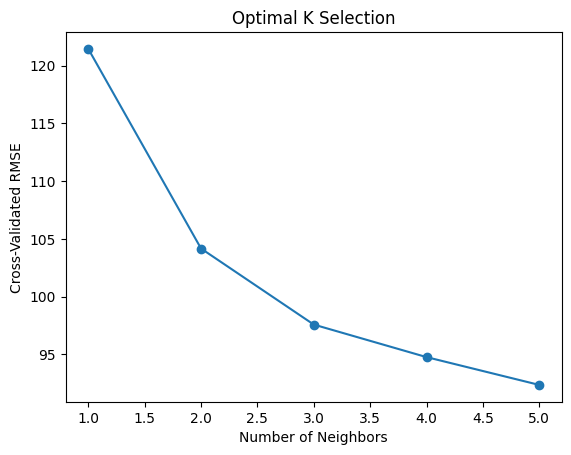

In [70]:
plt.plot(k_values, rmse_cv_scores, marker='o')
plt.xlabel("Number of Neighbors")
plt.ylabel("Cross-Validated RMSE")
plt.title("Optimal K Selection")
plt.show()

In [71]:
optimal_k = k_values[np.argmin(rmse_cv_scores)]
print(optimal_k)

5


In [72]:
knn_optimal = KNeighborsRegressor(n_neighbors=optimal_k)
knn_optimal.fit(x_train, y_train)
y_hat_optimal = knn_optimal.predict(x_test)

r2_knn = r2_score(y_test, y_hat_optimal)
print(f'R-squared for KNN Regression: {r2_knn:.4f}')

lr = LinearRegression()
lr.fit(x_train, y_train)
y_hat_lr = lr.predict(x_test)
r2_lr = r2_score(y_test, y_hat_lr)
print(f'R-squared for Multiple Regression: {r2_lr:.4f}')

if r2_knn > r2_lr:
    print("KNN Regression performs better.")
else:
    print("Multiple Regression performs better.")


R-squared for KNN Regression: 0.7550
R-squared for Multiple Regression: 0.3851
KNN Regression performs better.


In [73]:
y = (df['cnt'] > 500).astype(int)
df['overload'] = (df['cnt'] > 500).astype(int)

In [74]:
proportions = df['overload'].value_counts(normalize=True)
print(proportions)

overload
0    0.926405
1    0.073595
Name: proportion, dtype: float64


This dataset is very imbalanced because the proportions are not close to 50 percent

In [75]:
X = df.drop(columns=["cnt", "overload"])
y = df["overload"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [76]:
knn = KNeighborsClassifier()
knn.fit(x_train,y_train)

KNeighborsClassifier()

In [77]:
y_hat_probs = knn.predict_proba(x_test)[:, 1]
y_hat = (y_hat_probs >= 0.5).astype(int)

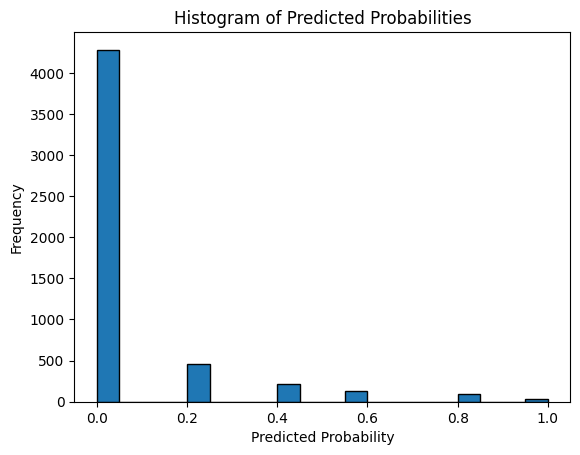

In [78]:
plt.hist(y_hat_probs, bins=20, edgecolor='black')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.show()

I see that most of the probabilites are below 0.3 so almost everything will be predicted negative. The threshold would have to be every single probability below 0.3 for negative and above for positive.

In [79]:
y_hat_30 = (y_hat_probs >= 0.3).astype(int)
y_hat_70 = (y_hat_probs >= 0.7).astype(int)

In [80]:
df_predictions = pd.DataFrame({
    'y_test': y_test,
    'y_hat': y_hat,
    'y_hat_30': y_hat_30,
    'y_hat_70': y_hat_70,
    'y_hat_probs': y_hat_probs
})

df_predictions.head()

,y_test,y_hat,y_hat_30,y_hat_70,y_hat_probs
12830,0,0,0,0,0.2
8688,0,0,0,0,0.0
7091,0,0,0,0,0.0
12230,1,0,0,0,0.2
431,0,0,0,0,0.0


In [81]:
def my_KNN_report(x_train, y_train, x_test,y_test, K=5, threshold=0.5, weights='uniform'):
    knn= KNeighborsClassifier(n_neighbors=K, weights=weights)
    knn.fit(x_train, y_train)
    probs = knn.predict_proba(x_test)[:,1]
    y_hat = np.where(probs>=threshold,1,0)

    cm = confusion_matrix(y_test, y_hat)
    accuracy = round(accuracy_score(y_test,y_hat) ,4)
    error_rate = round(1-accuracy,4)
    precision = round(precision_score(y_test,y_hat),2)
    recall = round(recall_score(y_test,y_hat),2)
    f1score = round(f1_score(y_test,y_hat),2)
    MCC = round(matthews_corrcoef(y_test,y_hat),2)
    cm_labled = pd.DataFrame(cm, index=['Actual : negative ','Actual : positive'], columns=['Predict : negative','Predict :positive '])

    print("-----------------------------------------")
    print('Accuracy  = {}'.format(accuracy))
    print('Error_rate  = {}'.format(error_rate))
    print('Precision = {}'.format(precision))
    print('Recall    = {}'.format(recall))
    print('f1_score  = {}'.format(f1score))
    print('MCC       = {}'.format(MCC))
    print("-----------------------------------------")
    return cm_labled


In [82]:
my_KNN_report(x_train, y_train, x_test, y_test, K=5, threshold=0.5, weights='uniform')

-----------------------------------------
Accuracy  = 0.9486
Error_rate  = 0.0514
Precision = 0.68
Recall    = 0.5
f1_score  = 0.58
MCC       = 0.56
-----------------------------------------


,Predict : negative,Predict :positive
Actual : negative,4763,87
Actual : positive,181,183


The accuracy was 94.86% which is high although isn't credible because there could be too much overload. This is the same with the error rate, it is good, but not trustworthy. When the model predicts an overload then it is right 68 percent of the time. This model only correctly identifies 50 percent of the overloads. The 58 percent f1 score tells us that this model is not very good at finding overloads. I do not trust the accuracy because the model misses a lot of overloads.

In [83]:
def my_KNN_report(x_train, y_train, x_test,y_test, K=5, threshold=0.3, weights='uniform'):
    knn= KNeighborsClassifier(n_neighbors=K, weights=weights)
    knn.fit(x_train, y_train)
    probs = knn.predict_proba(x_test)[:,1]
    y_hat = np.where(probs>=threshold,1,0)

    cm = confusion_matrix(y_test, y_hat)
    accuracy = round(accuracy_score(y_test,y_hat) ,4)
    error_rate = round(1-accuracy,4)
    precision = round(precision_score(y_test,y_hat),2)
    recall = round(recall_score(y_test,y_hat),2)
    f1score = round(f1_score(y_test,y_hat),2)
    MCC = round(matthews_corrcoef(y_test,y_hat),2)
    cm_labled = pd.DataFrame(cm, index=['Actual : negative ','Actual : positive'], columns=['Predict : negative','Predict :positive '])

    print("-----------------------------------------")
    print('Accuracy  = {}'.format(accuracy))
    print('Error_rate  = {}'.format(error_rate))
    print('Precision = {}'.format(precision))
    print('Recall    = {}'.format(recall))
    print('f1_score  = {}'.format(f1score))
    print('MCC       = {}'.format(MCC))
    print("-----------------------------------------")
    return cm_labled

In [84]:
my_KNN_report(x_train, y_train, x_test, y_test, K=5, threshold=0.3, weights='uniform')

-----------------------------------------
Accuracy  = 0.9413
Error_rate  = 0.0587
Precision = 0.56
Recall    = 0.74
f1_score  = 0.64
MCC       = 0.61
-----------------------------------------


,Predict : negative,Predict :positive
Actual : negative,4639,211
Actual : positive,95,269


The accuracy and recall stay about the same, precision decreases a little, and the rest increase. This means there are fewer false negatives and we miss less overloads. This shows that reducing the number of false negatives will increase more false positives.

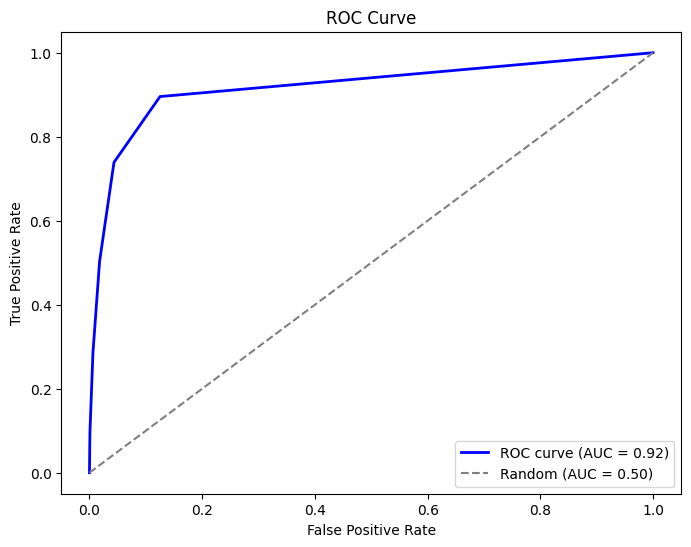

AUC Score: 0.9175


In [85]:
fpr, tpr, _ = roc_curve(y_test, y_hat_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()
print(f"AUC Score: {roc_auc:.4f}")


This model is doing much better than no skill with a 0.9175 versus a 0.50

In [87]:
k_values = range(1, 31)
error_rate_CV = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, x_train, y_train, cv=5, scoring='accuracy')
    error_rate_CV.append(1 - np.mean(scores))

optimal_k = k_values[np.argmin(error_rate_CV)]
print(f"Optimal K: {optimal_k}")

Optimal K: 9


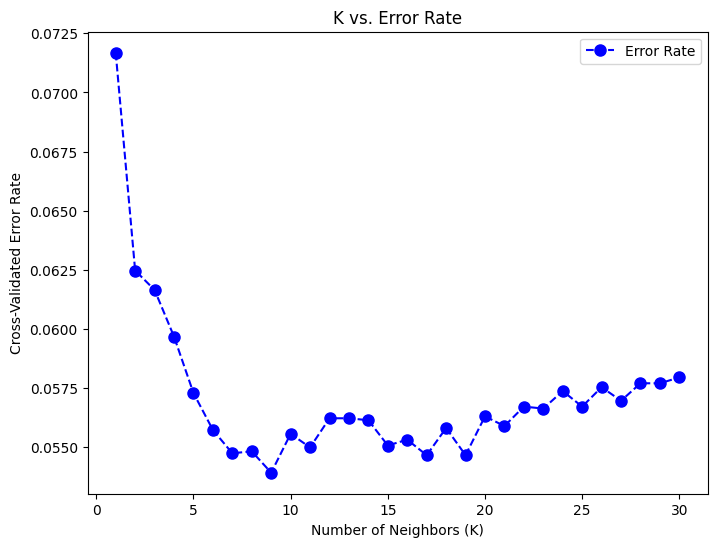

In [90]:
plt.figure(figsize=(8,6))
plt.plot(k_values, error_rate_CV, marker='o', linestyle='dashed', color='b', markersize=8, label='Error Rate')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validated Error Rate')
plt.title('K vs. Error Rate')
plt.legend()
plt.show()

The 0.3 threshold is best in this scenario because ywe want to reduce missed overloads. Since the cost of a single idle bike is smaller than the cost of a single unexpected overload, finding those unexpected overloads is more important.